In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from HanTa import HanoverTagger as ht


nltk.download('wordnet')
nltk.download("stopwords")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic Modelling

For topic modelling the same data set as for the sentiment analysis is used, which means that tweets not directly containing the hashtag, as well as retweets are removed. 

In [9]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag']]

In [10]:
#get the correct data
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df = df[df['text'].str.contains("#ichbinhanna", case = False)]
df['processed'] = df['text'].astype(str)
df = df.loc[(df['lang'] == 'de') | (df['lang'] == 'en')]

In [33]:
#clean the data (remove URLs, emojis and line breaks)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df['processed'] = df['processed'].apply(rem_url)
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['text'].replace(r'\\n',  ' ', regex=True)
df['processed'] = df['processed'].astype(str)

In [34]:
#preprocessing (tokenization, stop word removal, stemming)
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
add_stop_all = ["ichbinhanna","#ichbinhanna", "hanna", "mehr", "innen", "#wisszeitvg", "#ichbinhannah", "@amreibahr", "amreibahr", "@bmf_bund","bmf_bund" "@drkeichhorn", "@bmbf_bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre"]
german_stop.update(set(add_stop_all))
english_stop.update(set(add_stop_all))
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in english_stop]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in german_stop]).split(),axis=1)
#remove all words consisting of 3 characters or less to shorten the dictionary of unique words
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 3])
lemmatizer = WordNetLemmatizer()
hannover = ht.HanoverTagger('morphmodel_ger.pgz')
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: [lemmatizer.lemmatize(word).lower() for word in x['tokenized']] if x['lang'] == 'en' else [hannover.analyze(word)[0].lower() for word in x['tokenized']] ,axis=1)

In [35]:
def perform_LDA(tokens, topics=5, passes =5, alpha = 'symmetric', decay = 0.5):
    #create the dictionary of lemmatized tokens
    dic = Dictionary(tokens)
    print(len(dic))
    #remove low and high frequent terms
    dic.filter_extremes(no_below=2, no_above=.99)
    print(len(dic))
    #create the bag of words 
    corpus = [dic.doc2bow(d) for d in tokens]
    #build LDA model 
    LDA = LdaMulticore(corpus= corpus, num_topics=topics, id2word= dic, workers=12, passes=passes, alpha = alpha, decay = decay)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA.print_topics()]
    #create topics
    topics = [' '.join(t[0:10]) for t in words]

    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
    # Compute Perplexity
    perplexity = LDA.log_perplexity(corpus)
    print('\nPerplexity: ', perplexity) 
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=LDA, texts=tokens, 
                                   dictionary=dic, coherence='c_v')
    coherence_lda_model = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model)
    return LDA

In [36]:
#perform topic modelling by applying LDA on the whole data set, and on the german/english only sets (guided by: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
#full data set
full_model = perform_LDA(df['tokenized'])

47257
15484
------ Topic 0 ------
stellen gut prekär arbeit mensch @anjakarliczek machen befristet stelle jahr

------ Topic 1 ------
system schreiben werden arbeit machen contract thread finden gut @gew_bund

------ Topic 2 ------
immer befristet wissen system jahr #ichbinreyhan aktuell arbeit wissenschaftlich warum

------ Topic 3 ------
jahr gut forschung arbeit lehre ganz werden sehen haben bekommen

------ Topic 4 ------
#hannaimbundestag @anjakarliczek problem jahr @drkeichhorn #ichbinreyhan heute hochschule brauchen sagen


Perplexity:  -8.688823662221203

Coherence Score:  0.21040006615942378


In [37]:
#only german tweets
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]
ger_model = perform_LDA(df_ger['tokenized'])

39839
12611
------ Topic 0 ------
jahr zeit immer haben letzter müssen gut werden befristet forschung

------ Topic 1 ------
@drkeichhorn gut brauchen haben arbeit arbeitsbedingung prekär stellen gerade wissen

------ Topic 2 ------
jahr vertrag stellen befristet arbeit gut stelle danken werden neu

------ Topic 3 ------
ganz jahr deutschland arbeit wissenschaftlich machen system heute wissen immer

------ Topic 4 ------
@anjakarliczek gut befristet arbeit #hannaimbundestag forschung problem brauchen jahr #ichbinreyhan


Perplexity:  -8.482680206889254

Coherence Score:  0.15332127267382684


In [38]:
#only english tweets
en_model = perform_LDA(df_en['tokenized'])

9265
3329
------ Topic 0 ------
system need know working university people contract career position year

------ Topic 1 ------
thread research work researcher story contract want career university professor

------ Topic 2 ------
contract system career precarious position research researcher time many discussion

------ Topic 3 ------
#ichbinreyhan contract condition permanent system #hannaimbundestag change position working research

------ Topic 4 ------
like year work research thread much postdoc academic good think


Perplexity:  -7.81762358336423

Coherence Score:  0.23286907753350308


In [39]:
#get topics by month
df_june = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-06-30 23:59:59')]
df_july = df.loc[(df['new_date'] > '2021-07-01 00:00:00') & (df['new_date'] <= '2021-07-31 23:59:59')]
df_august = df.loc[(df['new_date'] > '2021-08-01 00:00:00') & (df['new_date'] <= '2021-08-31 23:59:59')]
df_september = df.loc[(df['new_date'] > '2021-09-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [40]:
#tweets from june
june_model = perform_LDA(df_june['tokenized'])

31219
10509
------ Topic 0 ------
gut system thread @drkeichhorn warum danken @sebastiankubon befristung aktuell heute

------ Topic 1 ------
@anjakarliczek #hannaimbundestag problem letzter sagen hashtag arbeitsbedingung forschung gerade stunde

------ Topic 2 ------
#hannaimbundestag @anjakarliczek forschung stellen brauchen video career werden promotion deutschland

------ Topic 3 ------
jahr befristet vertrag stelle bekommen forschung gut arbeit stellen machen

------ Topic 4 ------
arbeit jahr haben machen gut @anjakarliczek einfach immer wisszeitvg promotion


Perplexity:  -8.504807244258174

Coherence Score:  0.266107840360273


In [41]:
#tweets from july
july_model = perform_LDA(df_july['tokenized'])

16777
5787
------ Topic 0 ------
#ichbinreyhan gut @anjakarliczek danken lehre @gew_bund @drkeichhorn thema sehen arbeitsbedingung

------ Topic 1 ------
jahr @gew_bund wichtig promotion problem wissen machen gut stelle #ichbinreyhan

------ Topic 2 ------
stellen befristet #hannabeidergew @drkeichhorn thread hochschule @sebastiankubon müssen professur gerade

------ Topic 3 ------
immer #ichbinreyhan forschung brauchen @tagesthemen dauerstelle gut wissen kommentar zeit

------ Topic 4 ------
arbeit system gut @anjakarliczek haben problem contract brauchen gerade research


Perplexity:  -8.393642487434846

Coherence Score:  0.25117276813386663


In [42]:
#tweets from august
august_model = perform_LDA(df_august['tokenized'])

9924
3235
------ Topic 0 ------
#ichbinreyhan jahr sprechen wissenschaftlich aktuell #waspostdocswoll kommen folge innovation problem

------ Topic 1 ------
#ichbinreyhan arbeit #dauerstell @gew_bund machen system immer leben gut @drkeichhorn

------ Topic 2 ------
gut stellen wissen ganz arbeit finden @anjakarliczek #ichbinreyhan heute müssen

------ Topic 3 ------
@drkeichhorn forschung bleiben @sebastiankubon gut thema lehre machen @christine_blume position

------ Topic 4 ------
system #ichbinreyhan frage warum müssen wichtig hochschule @akellergew immer #wissenschaft


Perplexity:  -8.066175824493525

Coherence Score:  0.26265033282335687


In [43]:
#tweets from september
september_model = perform_LDA(df_september['tokenized'])

9239
3015
------ Topic 0 ------
vertrag brauchen jahr wissen #hannainzahlen ende professur müssen heute neu

------ Topic 1 ------
gut jahr sehen @gew_bund promotion immer problem neu arbeitsbedingung #ichbinreyhan

------ Topic 2 ------
#ichbinreyhan dürfen @gew_bund #dauerstell arbeit #wissenschaft neu stelle gut woche

------ Topic 3 ------
monat vertrag #ichbinreyhan finden befristet @drkeichhorn neu stellen eigentlich #berlhg

------ Topic 4 ------
#ichbinreyhan @gew_bund hochschule arbeit heute machen wichtig gut #entfristethanna @drkeichhorn


Perplexity:  -8.0305531436335

Coherence Score:  0.2911786685823949


In [44]:
def visualize_topics(tokens):
    #Visualization of topic distance 
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    #create the bag of words 
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    #build LDA model a 
    vis_LDA = LdaMulticore(corpus= vis_corpus, num_topics=5, id2word= vis_dic, workers=12, passes=5, random_state = 1)
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(vis_LDA, vis_corpus, vis_dic)
def visualize_model(model, tokens):
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(model, vis_corpus, vis_dic)

In [45]:
visualize_topics(df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.044950 -0.013076       1        1  23.977574
0     -0.017017 -0.005455       2        1  21.860849
2     -0.027861 -0.052095       3        1  20.049550
1      0.112843 -0.003728       4        1  17.788934
4     -0.023015  0.074354       5        1  16.323093, topic_info=                   Term         Freq        Total Category  logprob  loglift
2103  #hannaimbundestag   714.000000   714.000000  Default  30.0000  30.0000
945            position   262.000000   262.000000  Default  29.0000  29.0000
448              system   805.000000   805.000000  Default  28.0000  28.0000
41                  gut  1125.000000  1125.000000  Default  27.0000  27.0000
66                 zeit   533.000000   533.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
286             problem   110.425340   686.862051   Topic5  -5.8247  -0.0152
124    wissenschaftlich    95.339115   471.931725   Topic5  -5.9716   0.2132
284               lehre    96.526740   528.565627   Topic5  -5.9592   0.1122
335                ganz    93.330331   615.447975   Topic5  -5.9929  -0.0736
607               haben    88.500754   542.179031   Topic5  -6.0460   0.0000

[463 rows x 6 columns], token_table=       Topic      Freq                          Term
term                                                
520        1  0.078566  #acertaindegreeofflexibility
520        2  0.286535  #acertaindegreeofflexibility
520        3  0.106295  #acertaindegreeofflexibility
520        4  0.097052  #acertaindegreeofflexibility
520        5  0.434424  #acertaindegreeofflexibility
...      ...       ...                           ...
3832       4  0.059410                        ️https
3832       5  0.118819                        ️https
14974      1  0.090748                   ️stipendium
14974      3  0.090748                   ️stipendium
14974      5  0.816729                   ️stipendium

[1247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

In [90]:
def create_dic_corpus(tokens):
    dic = Dictionary(tokens)
    dic.filter_extremes(no_below=2, no_above=.99)
    corpus = [dic.doc2bow(d) for d in tokens]
    return dic, corpus
#get optimal number of topics for each (sub)set
def compute_coherence_values_topics(tokens, limit=10, start=2, step=1):
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, random_state = 1)
        model_list_topic.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    print(model_list_topic, coherence_values_topic)
    
def compute_coherence_values_passes(tokens,num_topics):
    
    passes = [5,10,15,20]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_passes = []
    model_list_passes = []
    for num_pass in passes:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = num_pass, random_state = 1)
        model_list_passes.append(num_pass)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_passes.append(coherencemodel.get_coherence())

    print(model_list_passes, coherence_values_passes)
    
def compute_coherence_values_alpha(tokens,num_topics, passes):
    
    alpha = ['symmetric','asymmetric']
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_alpha = []
    model_list_alpha = []
    for a in alpha:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = a, random_state = 1)
        model_list_alpha.append(a)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    print(model_list_alpha, coherence_values_alpha)
    
def compute_coherence_values_decay(tokens,num_topics, passes, alpha):
    
    decay = [0.5,0.7,0.9]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_decay = []
    model_list_decay = []
    for d in decay:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = alpha, random_state = 1, decay =d)
        model_list_decay.append(d)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_decay.append(coherencemodel.get_coherence())

    print(model_list_decay, coherence_values_decay)

In [47]:
#full data
compute_coherence_values_topics(df['tokenized'])
#english data
compute_coherence_values_topics(df_en['tokenized'])
#german data
compute_coherence_values_topics(df_ger['tokenized'])
#june data
compute_coherence_values_topics(df_june['tokenized'])
#july data
compute_coherence_values_topics(df_july['tokenized'])
#august data
compute_coherence_values_topics(df_august['tokenized'])
#september data
compute_coherence_values_topics(df_september['tokenized'])

[2, 3, 4, 5, 6, 7, 8, 9] [0.13405187887830733, 0.1160297259350566, 0.13899913094186578, 0.14327685938154638, 0.16169150376444238, 0.15938465807588667, 0.17418611131250866, 0.18177669829945303]
[2, 3, 4, 5, 6, 7, 8, 9] [0.16234242796387693, 0.17277464914117802, 0.20823664213440943, 0.2156692041253311, 0.22551931361967234, 0.2288153105416723, 0.23414955230680073, 0.23777557469383698]
[2, 3, 4, 5, 6, 7, 8, 9] [0.09319749537390119, 0.10183531957494164, 0.123565031088746, 0.14685188068730076, 0.1619520044638684, 0.16065206442219873, 0.18442749707252273, 0.18666497060458825]
[2, 3, 4, 5, 6, 7, 8, 9] [0.1195454651300592, 0.12908044122389797, 0.13726005872814545, 0.14372180891644876, 0.18828821296405052, 0.19569159289850876, 0.20235397516466802, 0.20244774279581024]
[2, 3, 4, 5, 6, 7, 8, 9] [0.15892371004881145, 0.1775048501129118, 0.2659716139993553, 0.23674579928150888, 0.2789079555748088, 0.2809982006190485, 0.27158001580741703, 0.2712769480380678]
[2, 3, 4, 5, 6, 7, 8, 9] [0.22710071261761

In [59]:
#full data
compute_coherence_values_passes(df['tokenized'], 6)
#english data
compute_coherence_values_passes(df_en['tokenized'],7)
#german data
compute_coherence_values_passes(df_ger['tokenized'],8)
#june data
compute_coherence_values_passes(df_june['tokenized'],7)
#july data
compute_coherence_values_passes(df_july['tokenized'],7)
#august data
compute_coherence_values_passes(df_august['tokenized'],7)
#september data
compute_coherence_values_passes(df_september['tokenized'],6)

[5, 10, 15, 20] [0.212218771851537, 0.2955262696190602, 0.3205591170472739, 0.32802206676738344]
[5, 10, 15, 20] [0.24773375156291225, 0.25428524076056647, 0.25610794571292944, 0.261375757707735]
[5, 10, 15, 20] [0.18338759312455377, 0.21101383892623, 0.22950958433907473, 0.2383432956267168]
[5, 10, 15, 20] [0.23454161341434945, 0.26644527840878146, 0.23770660868449373, 0.2811635895540894]
[5, 10, 15, 20] [0.24230949297269083, 0.25955190365122466, 0.2716258720643634, 0.2572089811286599]
[5, 10, 15, 20] [0.2648714772355537, 0.2993159772474564, 0.29743070346239203, 0.3001825784550061]
[5, 10, 15, 20] [0.3143185246125852, 0.31957037507095887, 0.3434326529387925, 0.3466892893308904]


In [70]:
#full data
compute_coherence_values_alpha(df['tokenized'], 6,20)
#english data
compute_coherence_values_alpha(df_en['tokenized'],7,20)
#german data
compute_coherence_values_alpha(df_ger['tokenized'],8,20)
#june data
compute_coherence_values_alpha(df_june['tokenized'],7,20)
#july data
compute_coherence_values_alpha(df_july['tokenized'],7,15)
#august data
compute_coherence_values_alpha(df_august['tokenized'],7,20)
#september data
compute_coherence_values_alpha(df_september['tokenized'],6,20)

['symmetric', 'asymmetric'] [0.32802206676738344, 0.3472572605196181]
['symmetric', 'asymmetric'] [0.261375757707735, 0.2353166619841747]
['symmetric', 'asymmetric'] [0.23848325199180498, 0.22095341862686518]
['symmetric', 'asymmetric'] [0.28336796683492, 0.3205047020800164]
['symmetric', 'asymmetric'] [0.2716258720643634, 0.3214927023042512]
['symmetric', 'asymmetric'] [0.3001825784550061, 0.3314629502732684]
['symmetric', 'asymmetric'] [0.3466892893308904, 0.33009107636043467]


In [71]:
#full data
compute_coherence_values_decay(df['tokenized'], 6,20,'asymmetric')
#english data
compute_coherence_values_decay(df_en['tokenized'],7,20,'symmetric')
#german data
compute_coherence_values_decay(df_ger['tokenized'],8,20,'symmetric')
#june data
compute_coherence_values_decay(df_june['tokenized'],7,20,'asymmetric')
#july data
compute_coherence_values_decay(df_july['tokenized'],7,20,'asymmetric')
#august data
compute_coherence_values_decay(df_august['tokenized'],7,20,'asymmetric')
#september data
compute_coherence_values_decay(df_september['tokenized'],6,5,'symmetric')

[0.5, 0.7, 0.9] [0.34747926816119473, 0.3292991042287408, 0.27359722614252885]
[0.5, 0.7, 0.9] [0.261375757707735, 0.2537053561724899, 0.24883893263630533]
[0.5, 0.7, 0.9] [0.23848325199180492, 0.21283653103356187, 0.18479699208798508]
[0.5, 0.7, 0.9] [0.32038834725586296, 0.2923483372098268, 0.23802951059131786]
[0.5, 0.7, 0.9] [0.3355289473067389, 0.3163108068230526, 0.31670349106756274]
[0.5, 0.7, 0.9] [0.3314629502732684, 0.3372607488559632, 0.3196148743556707]
[0.5, 0.7, 0.9] [0.3143185246125852, 0.3116388851901153, 0.3079800515728264]


In [72]:
#get the optimal models
optimal_full = perform_LDA(df['tokenized'],6,20,'asymmetric',0.5)
optimal_en = perform_LDA(df_en['tokenized'],7,20,'symmetric',0.5)
optimal_ger = perform_LDA(df_ger['tokenized'],8,20,'symmetric',0.5)
optimal_june = perform_LDA(df_june['tokenized'],7,20,'asymmetric',0.5)
optimal_july = perform_LDA(df_july['tokenized'],7,20,'asymmetric',0.5)
optimal_august = perform_LDA(df_august['tokenized'],7,20,'asymmetric',0.7)
optimal_september = perform_LDA(df_september['tokenized'],6,5,'asymmetric',0.5)

47257
15484
------ Topic 0 ------
gut arbeit forschung befristet #hannaimbundestag @anjakarliczek #ichbinreyhan lehre wichtig thread

------ Topic 1 ------
jahr machen @anjakarliczek wissen immer ganz warum werden arbeit frage

------ Topic 2 ------
befristet stellen stelle monat jahr vertrag unbefristet neu problem hochschule

------ Topic 3 ------
system contract research work year career researcher position many university

------ Topic 4 ------
aktuell thema stunde bundestag #hannaimbundestag heute finden groß ganz #dauerstell

------ Topic 5 ------
immer promotion professor müssen jahr postdocs werden arbeit system stellen


Perplexity:  -8.522423340607086

Coherence Score:  0.37017342424198957
9265
3329
------ Topic 0 ------
thread system work #hannaimbundestag problem scholar check people would research

------ Topic 1 ------
contract year like many career researcher time student university system

------ Topic 2 ------
research system precarity future much problem like great sc

In [73]:
visualize_model(optimal_full, df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.071772 -0.001665       1        1  33.172965
1     -0.120578  0.016468       2        1  32.338795
2     -0.083889  0.037891       3        1  12.257362
3      0.354656 -0.007176       4        1  11.345965
4     -0.059454 -0.166124       5        1   6.073775
5     -0.018963  0.120605       6        1   4.811139, topic_info=            Term        Freq       Total Category  logprob  loglift
930        immer  695.000000  695.000000  Default  30.0000  30.0000
99       aktuell  372.000000  372.000000  Default  29.0000  29.0000
107        thema  430.000000  430.000000  Default  28.0000  28.0000
171    promotion  524.000000  524.000000  Default  27.0000  27.0000
2966    contract  244.000000  244.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1317     weniger   23.091218  198.461332   Topic6  -6.1679   0.8831
323    forschung   27.365288  736.595135   Topic6  -5.9981  -0.2585
596   innovation   23.792579  261.269759   Topic6  -6.1380   0.6381
945     position   22.524742  263.117012   Topic6  -6.1927   0.5763
56    hochschule   22.735713  533.097603   Topic6  -6.1834  -0.1205

[491 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
480       1  0.766940  #95vswisszeitvg
480       2  0.152709  #95vswisszeitvg
480       3  0.006787  #95vswisszeitvg
480       4  0.054297  #95vswisszeitvg
480       5  0.010181  #95vswisszeitvg
...     ...       ...              ...
1319      1  0.875496       überstunde
1319      2  0.014839       überstunde
1319      3  0.014839       überstunde
1319      5  0.014839       überstunde
1319      6  0.059356       überstunde

[1280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [74]:
visualize_model(optimal_en, df_en['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.100066 -0.016264       1        1  20.416561
6      0.024939 -0.028100       2        1  16.471202
3     -0.020276 -0.055839       3        1  14.974885
2      0.029784 -0.012155       4        1  14.034667
5     -0.071888 -0.043045       5        1  12.663324
0      0.147899 -0.020066       6        1  11.361226
4     -0.010392  0.175468       7        1  10.078135, topic_info=          Term        Freq       Total Category  logprob  loglift
820      story   74.000000   74.000000  Default  30.0000  30.0000
69      thread  150.000000  150.000000  Default  29.0000  29.0000
58        year  164.000000  164.000000  Default  28.0000  28.0000
343     career  155.000000  155.000000  Default  27.0000  27.0000
782      share   56.000000   56.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
49        know   11.741210  104.502205   Topic7  -5.5374   0.1087
177     people   11.757369  122.859046   Topic7  -5.5360  -0.0518
138     system   11.885675  236.751930   Topic7  -5.5252  -0.6969
110  different   10.257567   34.127612   Topic7  -5.6725   1.0927
69      thread   10.258874  150.385378   Topic7  -5.6724  -0.3903

[580 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1605      1  0.117012   #95vswisszeitvg
1605      3  0.643568   #95vswisszeitvg
1605      7  0.204772   #95vswisszeitvg
191       1  0.189057  #academictwitter
191       2  0.504152  #academictwitter
...     ...       ...               ...
58        7  0.085267              year
80        1  0.598223             young
80        4  0.289463             young
80        5  0.038595             young
80        7  0.057893             young

[1340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 3, 6, 1, 5])

In [75]:
visualize_model(optimal_ger, df_ger['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.083221 -0.018578       1        1  14.902657
5      0.094957  0.015414       2        1  14.803244
6     -0.048127 -0.025382       3        1  13.030747
7     -0.029414 -0.022934       4        1  12.632104
2      0.019416  0.053013       5        1  11.827137
3     -0.082752  0.117392       6        1  11.284074
4      0.034415 -0.015617       7        1  10.774604
0     -0.071716 -0.103307       8        1  10.745434, topic_info=                Term         Freq        Total Category  logprob  loglift
304        @gew_bund   415.000000   415.000000  Default  30.0000  30.0000
260           thread   261.000000   261.000000  Default  29.0000  29.0000
784          vertrag   562.000000   562.000000  Default  28.0000  28.0000
506  @sebastiankubon   285.000000   285.000000  Default  27.0000  27.0000
20               gut  1136.000000  1136.000000  Default  26.0000  26.0000
..               ...          ...          ...      ...      ...      ...
693   @anjakarliczek    76.566077   853.098701   Topic8  -5.6273  -0.1800
240          wichtig    67.101400   520.127636   Topic8  -5.7592   0.1828
443            leute    61.098200   364.751798   Topic8  -5.8530   0.4440
481           wissen    67.593237   671.866739   Topic8  -5.7519  -0.0659
81            werden    63.297917   622.804109   Topic8  -5.8176  -0.0557

[685 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
438        1  0.118709           #95vswisszeitvg
438        2  0.019147           #95vswisszeitvg
438        3  0.294858           #95vswisszeitvg
438        4  0.137856           #95vswisszeitvg
438        5  0.042123           #95vswisszeitvg
...      ...       ...                       ...
12138      1  0.907354          ️arbeitsverträge
12140      1  0.966554                     ️ende
12141      1  0.943106  ️erwerbsarbeitslosigkeit
12142      1  0.931860                   ️kinder
12144      1  0.960048               ️stipendium

[2077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 8, 3, 4, 5, 1])

In [76]:
visualize_model(optimal_june, df_june['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.065672 -0.080014       1        1  44.259648
1     -0.034404  0.022254       2        1  13.712442
2      0.299282  0.029072       3        1  11.501365
6     -0.086907  0.094499       4        1   9.055967
5     -0.075152  0.089129       5        1   7.747116
4     -0.011510 -0.159351       6        1   7.124354
3     -0.025636  0.004411       7        1   6.599109, topic_info=           Term        Freq       Total Category  logprob  loglift
304        jahr  963.000000  963.000000  Default  30.0000  30.0000
138   befristet  571.000000  571.000000  Default  29.0000  29.0000
551      stelle  335.000000  335.000000  Default  28.0000  28.0000
13    promotion  356.000000  356.000000  Default  27.0000  27.0000
1112    vertrag  370.000000  370.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
250     problem   25.857893  415.215888   Topic7  -5.8044  -0.0579
1725     lassen   22.393751  224.147547   Topic7  -5.9482   0.4147
444        jung   21.351783  177.771066   Topic7  -5.9959   0.5989
301       frage   21.761713  241.855009   Topic7  -5.9768   0.3100
113   professor   19.585973  152.593761   Topic7  -6.0822   0.6653

[553 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
1422      1  0.961671  #anschlussverwendung
907       3  0.939664                #bipoc
1327      1  0.903293                 #bmbf
1327      2  0.009217                 #bmbf
1327      3  0.009217                 #bmbf
...     ...       ...                   ...
1172      6  0.051010                ändern
3152      1  0.941313            ökonomisch
2746      5  0.260500           überflüssig
2746      6  0.694668           überflüssig
1771      7  0.910243           übertrieben

[1486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 7, 6, 5, 4])

In [77]:
visualize_model(optimal_july, df_july['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.105330 -0.026210       1        1  41.067136
2     -0.102631 -0.043185       2        1  18.170879
1      0.307463 -0.061627       3        1  16.533377
3     -0.072255 -0.043307       4        1   9.011140
4     -0.017337 -0.010492       5        1   5.808533
5     -0.049099 -0.013606       6        1   5.486762
6      0.039188  0.198426       7        1   3.922173, topic_info=             Term        Freq       Total Category  logprob  loglift
10           work   68.000000   68.000000  Default  30.0000  30.0000
527       stellen  151.000000  151.000000  Default  29.0000  29.0000
781         immer  147.000000  147.000000  Default  28.0000  28.0000
614   dauerstelle   77.000000   77.000000  Default  27.0000  27.0000
3129        story   30.000000   30.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
191     befristet    9.367172  145.005307   Topic7  -5.2814   0.4990
108     situation    6.598177   50.734596   Topic7  -5.6318   1.1987
157     promotion    6.767520   81.703119   Topic7  -5.6065   0.7476
144    vielleicht    6.529850   58.530971   Topic7  -5.6422   1.0454
705       vertrag    6.441585   69.504550   Topic7  -5.6559   0.8599

[500 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
971       6  0.622422            #abo
2955      1  0.215367         #berlin
2955      3  0.107684         #berlin
2955      5  0.646102         #berlin
3594      1  0.877406           #bmbf
...     ...       ...             ...
902       6  0.092517  öffentlichkeit
5481      6  0.622479        übergang
2266      1  0.111917          üblich
2266      5  0.111917          üblich
2266      6  0.671499          üblich

[1085 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5, 6, 7])

In [78]:
visualize_model(optimal_august, df_august['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.033577  0.021865       1        1  40.729706
1      0.041451  0.016695       2        1  21.844849
2      0.041957  0.030263       3        1  13.363562
4      0.128929 -0.094854       4        1   7.268393
3     -0.052232  0.108710       5        1   6.550828
5     -0.054852  0.044453       6        1   5.912341
6     -0.138831 -0.127133       7        1   4.330322, topic_info=                Term       Freq      Total Category  logprob  loglift
61      @drkeichhorn  84.000000  84.000000  Default  30.0000  30.0000
62   @sebastiankubon  44.000000  44.000000  Default  29.0000  29.0000
97          sprechen  42.000000  42.000000  Default  28.0000  28.0000
229          aktuell  46.000000  46.000000  Default  27.0000  27.0000
39       #dauerstell  44.000000  44.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
70            denken   2.621631  38.500538   Topic7  -5.8363   0.4527
1            deutsch   2.532361  38.153311   Topic7  -5.8709   0.4271
153          working   2.181114   9.645845   Topic7  -6.0202   1.6528
305             jahr   2.191175  62.186919   Topic7  -6.0156  -0.2062
145             know   2.181152  12.366939   Topic7  -6.0202   1.4044

[509 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
60        1  0.257470   #95vswisszeitvg
60        3  0.308964   #95vswisszeitvg
60        4  0.411952   #95vswisszeitvg
2387      2  0.754178  #academicchatter
114       6  0.867122  #academictwitter
...     ...       ...               ...
1278      5  0.454148           zwingen
516       1  0.812902            äußern
516       6  0.101613            äußern
1402      4  0.088172           überall
1402      7  0.881718           überall

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6, 7])

In [80]:
visualize_model(optimal_september, df_september['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.008362 -0.015262       1        1  47.602745
1      0.042102 -0.064194       2        1  20.264192
2      0.111717  0.093871       3        1  11.295052
5     -0.102646  0.096999       4        1   8.973354
3      0.021093 -0.059710       5        1   7.128159
4     -0.063904 -0.051705       6        1   4.736498, topic_info=          Term       Freq      Total Category  logprob  loglift
51     vertrag  66.000000  66.000000  Default  30.0000  30.0000
27        jahr  88.000000  88.000000  Default  29.0000  29.0000
192  @gew_bund  94.000000  94.000000  Default  28.0000  28.0000
186      monat  52.000000  52.000000  Default  27.0000  27.0000
10         neu  78.000000  78.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
148     wissen   2.370218  49.284084   Topic6  -5.9062   0.0153
112     prekär   2.255259  41.439765   Topic6  -5.9559   0.1389
20      machen   2.255933  63.314339   Topic6  -5.9556  -0.2847
639    einfach   2.195351  26.211207   Topic6  -5.9829   0.5700
113    studium   2.185360  23.182344   Topic6  -5.9874   0.6883

[461 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
77        1  0.793824  #95vswisszeitvg
77        2  0.144332  #95vswisszeitvg
77        3  0.072166  #95vswisszeitvg
1573      2  0.726913           #bafög
1573      4  0.145383           #bafög
...     ...       ...              ...
2412      5  0.406373          ️kinder
2690      5  0.839512          ️stelle
2414      1  0.100711      ️stipendium
2414      3  0.503555      ️stipendium
2414      5  0.302133      ️stipendium

[934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 6, 4, 5])

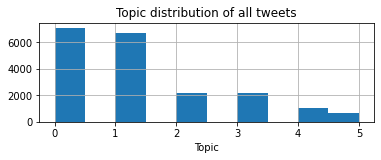

In [166]:
#explicitly get topic distribution (to get total number of tweets per topic)
def get_top_topic(distribution):
    top_topic = 0
    top_prob = 0 
    for topic in distribution:
        if topic[1] > top_prob:
            top_topic = topic[0]
            top_prob = topic[1] 
    return top_topic
#get topic probabilities for all tweets
full_dic, full_corpus = create_dic_corpus(df['tokenized'])
df['topic distribution'] = df['tokenized'].apply(lambda x: optimal_full.get_document_topics(full_dic.doc2bow(x)))
df['topic'] = df['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
plt.subplot(211)
df['topic'].hist()
plt.title('Topic distribution of all tweets')
plt.xlabel('Topic')
plt.show()

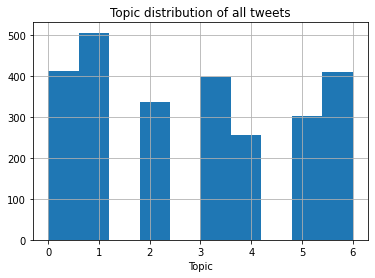

In [139]:
#get topic probabilities for all tweets
en_dic, en_corpus = create_dic_corpus(df_en['tokenized'])
df_en['topic distribution'] = df_en['tokenized'].apply(lambda x: optimal_en.get_document_topics(en_dic.doc2bow(x)))
df_en['topic'] = df_en['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_en['topic'].hist()
plt.title('Topic distribution of english tweets')
plt.xlabel('Topic')
plt.show()

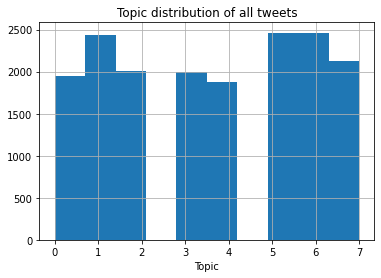

In [140]:
#get topic probabilities for all tweets
ger_dic, ger_corpus = create_dic_corpus(df_ger['tokenized'])
df_ger['topic distribution'] = df_ger['tokenized'].apply(lambda x: optimal_ger.get_document_topics(ger_dic.doc2bow(x)))
df_ger['topic'] = df_ger['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_ger['topic'].hist()
plt.title('Topic distribution of german tweets')
plt.xlabel('Topic')
plt.show()

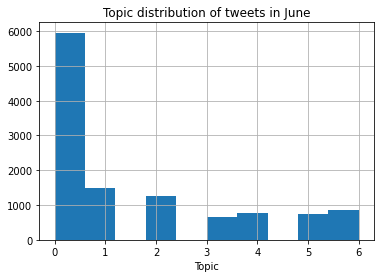

In [164]:
#get topic probabilities for all tweets
june_dic, june_corpus = create_dic_corpus(df_june['tokenized'])
df_june['topic distribution'] = df_june['tokenized'].apply(lambda x: optimal_june.get_document_topics(june_dic.doc2bow(x)))
df_june['topic'] = df_june['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_june['topic'].hist()
plt.title('Topic distribution of tweets in June')
plt.xlabel('Topic')
plt.show()

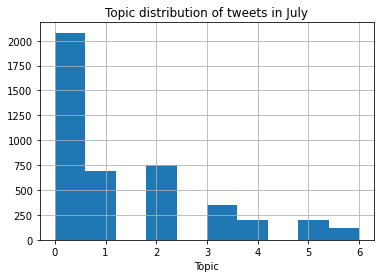

In [142]:
#get topic probabilities for all tweets
july_dic, july_corpus = create_dic_corpus(df_july['tokenized'])
df_july['topic distribution'] = df_july['tokenized'].apply(lambda x: optimal_july.get_document_topics(july_dic.doc2bow(x)))
df_july['topic'] = df_july['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_july['topic'].hist()
plt.title('Topic distribution of tweets in July')
plt.xlabel('Topic')
plt.show()

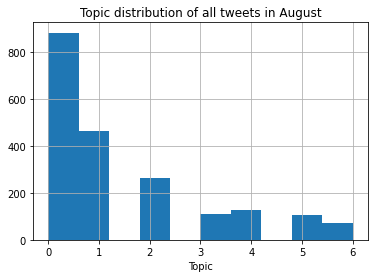

In [144]:
#get topic probabilities for all tweets
august_dic, august_corpus = create_dic_corpus(df_august['tokenized'])
df_august['topic distribution'] = df_august['tokenized'].apply(lambda x: optimal_august.get_document_topics(august_dic.doc2bow(x)))
df_august['topic'] = df_august['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_august['topic'].hist()
plt.title('Topic distribution of all tweets in August')
plt.xlabel('Topic')
plt.show()

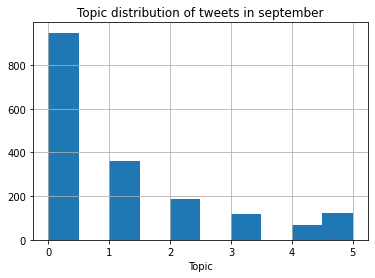

In [145]:
#get topic probabilities for all tweets
september_dic, september_corpus = create_dic_corpus(df_september['tokenized'])
df_september['topic distribution'] = df_september['tokenized'].apply(lambda x: optimal_september.get_document_topics(september_dic.doc2bow(x)))
df_september['topic'] = df_september['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_september['topic'].hist()
plt.title('Topic distribution of tweets in september')
plt.xlabel('Topic')
plt.show()